# LLM Training Data Augmentation - Classification of Kaggle Disaster Data

The goal of this notebook is to prepare the data for augmentation by an LLM and classification by two models:

1. Logistic regression
2. Single hidden-layer neural network

## Data

The data used in this project comes from the kaggle *Natural Language Processing with Disaster Tweets* competition at:  

https://www.kaggle.com/competitions/nlp-getting-started/data

This data consists of two files:
+ *train.csv* - 7485 labled tweets **after duplicate removals** 
+ *test.csv* - 3263 unlabled tweets

Because the *test.csv* labels are not available, the *train.csv* file was split into the following two files:

+ train_model.csv - data used to train model, 5988 labeled tweets
+ train_test.csv - held out and not used to train model, used as *pseudo-test* data, 1497 labeled tweets (~20% of the original training sample)

## Simplier NLP Classifier Models

Two types of models are created and compared:

1. Logistic Regression - This serves as the baseline
2. Single-Hidden layer neural network with 1000 nodes in the hidden layer

## LLM

ChatGPT 3.5 turbo will be used to augment the data used to train the models.

## Encodings

The Twitter GloVe embedding will be used to vectorize the input text.  These embeddings were downloaded from:

https://nlp.stanford.edu/data/glove.twitter.27B.zip


## Vectorize with all cleaned tweet tokens

Since the max number of tokens in the cleaned original training data is 29 and 26 for the cleaned augmented data, a 30 token input will be selected.  This will give us an input to the model that is 30 (tokens / tweet) x (50 dimensions / token) = 1500 dimensions / tweet.

Since all tweets will be less than 30 tokens, each input will be padded with the empty string token (<>).

## Build feature matrices

The following 4 feature matrices are built and exported so the can be read back in during modeling:

+ **feats_matrix_aug.txt** - 7485 rows where each row is a vectorized tweet padded to 30 tokens where each token is represented by a 50d GloVe twitter embedding and the empty string is used as the padding token.  1500 cols are the tweets padded to 30 tokens which are each converted to a 50d GloVe embedding
+ **feats_matrix_train_train.txt** - 80% of the original training data used to train each model, same vectorization as **feats_matrix_aug.txt**, xxxx rows, yyyy columns
+ **feats_matrix_train_test.txt** - 20% of the original training data used to test each model, same vectorization as **feats_matrix_aug.txt**, xxxx rows, yyyy columns
+ **feats_matrix_test.txt** - unlabeled test data provided by kaggle to test submissions, same vectorization as **feats_matrix_aug.txt**, xxxx rows, yyyy columns

The first 3 feature matrices have the following corresponding labels (`feats_matrix_test.txt` are unlabeled tweets):
+ labels_aug.txt
+ labels_train_train.txt
+ labels_train_test.txt

In [1]:
import projtools as pt
import numpy as np
import pandas as pd
%pwd

'D:\\llmamd'

In [2]:
# read in the feature matrices
feats_matrix_train_train = np.loadtxt('./data/feats_matrix_train_train.txt')
feats_matrix_train_test = np.loadtxt('./data/feats_matrix_train_test.txt')
feats_matrix_aug = np.loadtxt('./data/feats_matrix_aug.txt')
feats_matrix_test = np.loadtxt('./data/feats_matrix_test.txt')
# read in the labels
labels_train_train = np.loadtxt('./data/labels_train_train.txt', dtype='int')
labels_train_test = np.loadtxt('./data/labels_train_test.txt', dtype='int')
labels_aug = np.loadtxt('./data/labels_aug.txt', dtype='int')
print(f"shape of train train feature matrix: {feats_matrix_train_train.shape}, shape of train train labels: {labels_train_train.shape}")
print(f"dtype of train train labels: {labels_train_train.dtype}")
print(f"shape of train test feature matrix: {feats_matrix_train_test.shape}, shape of train test labels: {labels_train_test.shape}")
print(f"dtype of train test labels: {labels_train_test.dtype}")
print(f"shape of augmented feature matrix: {feats_matrix_aug.shape}, shape of augmented labels: {labels_aug.shape}")
print(f"dtype of augmented labels: {labels_aug.dtype}")
print(f"shape of (unlabeled) test feature matrix: {feats_matrix_test.shape}")

shape of train train feature matrix: (5988, 1500), shape of train train labels: (5988,)
dtype of train train labels: int32
shape of train test feature matrix: (1497, 1500), shape of train test labels: (1497,)
dtype of train test labels: int32
shape of augmented feature matrix: (7485, 1500), shape of augmented labels: (7485,)
dtype of augmented labels: int32
shape of (unlabeled) test feature matrix: (3263, 1500)


In [3]:
labels_train_train[:30]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1])

## Logistic regression models

### Just the original training data

**Intial results:**

+ Train Training error:  0.201737
+ Train Test error:  0.275217

In [4]:
from sklearn.linear_model import SGDClassifier

## fit logistic classifier on training data: minimize neg log likelihood ("log"), no regularization penalty
logreg_model_orig = SGDClassifier(loss="log_loss", penalty=None)
logreg_model_orig.fit(feats_matrix_train_train, labels_train_train)

## Pull out the parameters (w,b) of the logistic regression model
w = logreg_model_orig.coef_[0,:]
b = logreg_model_orig.intercept_

In [5]:
## Get predictions on training and test data
preds_train = logreg_model_orig.predict(feats_matrix_train_train)
preds_test = logreg_model_orig.predict(feats_matrix_train_test)

## Compute errors
errs_train = np.sum((preds_train > 0.0) != (labels_train_train > 0.0))
errs_test = np.sum((preds_test > 0.0) != (labels_train_test > 0.0))

error_rate_train_train = float(errs_train)/len(labels_train_train)
error_rate_train_test = float(errs_test)/len(labels_train_test)

print("Training error: ", error_rate_train_train)
print("Test error: ", error_rate_train_test)

Training error:  0.20691382765531063
Test error:  0.29792919171676685


### The original training data PLUS the augmented data

Now we'll add the augmented data to the training data and see if this improves our results.

**Training error was cut in half, but test only improved slightly - initial results:**

+ Training error:  0.108365
+ Test error:  0.271209

In [6]:
# create train + aug feature and label inputs
train_train_aug_data = np.vstack((feats_matrix_train_train, feats_matrix_aug))
train_train_aug_labels = np.hstack((labels_train_train, np.array(labels_aug)))
print(train_train_aug_data.shape, train_train_aug_labels.shape)

(13473, 1500) (13473,)


In [7]:
## fit logistic classifier on training data: minimize neg log likelihood ("log"), no regularization penalty
logreg_model_aug = SGDClassifier(loss="log_loss", penalty=None)
logreg_model_aug.fit(train_train_aug_data, train_train_aug_labels)

## Pull out the parameters (w,b) of the logistic regression model
w = logreg_model_aug.coef_[0,:]
b = logreg_model_aug.intercept_

In [8]:
## Get predictions on training and test data
preds_train_aug = logreg_model_aug.predict(train_train_aug_data)
preds_test_aug = logreg_model_aug.predict(feats_matrix_train_test)  # same train TEST partition, but different model

## Compute errors
errs_train_aug = np.sum((preds_train_aug > 0.0) != (train_train_aug_labels > 0.0))
errs_test_aug = np.sum((preds_test_aug > 0.0) != (labels_train_test > 0.0))  # same train TEST partition, but different model

error_rate_train_aug_train = float(errs_train_aug)/len(train_train_aug_labels)
error_rate_train_aug_test = float(errs_test_aug)/len(labels_train_test)

print(f"Training error with aug data: {error_rate_train_aug_train}")
print(f"Test error with aug data: {error_rate_train_aug_test}")

Training error with aug data: 0.10754843019372078
Test error with aug data: 0.27655310621242485


In [9]:
acc_train_train_orig = 1. - error_rate_train_train
acc_train_train_aug = 1. - error_rate_train_aug_train
acc_train_test_orig = 1. - error_rate_train_test
acc_train_test_aug = 1. - error_rate_train_aug_test

per_change_train_train_accuracy = 100. * ((acc_train_train_aug - acc_train_train_orig) / acc_train_train_orig)
per_change_train_test_accuracy = 100. * ((acc_train_test_aug - acc_train_test_orig) / acc_train_test_orig)

print(f"Train-Train error rate on original data: {error_rate_train_train:.4f}, Train-Test error rate on original data: {error_rate_train_test:.4f}")
print(f"Train-Train error rate on orig+aug data: {error_rate_train_aug_train:.4f}, Train-Test error rate on orig+aug data: {error_rate_train_aug_test:.4f}")
print()
print(f"Train-Train accuracy on original data: {acc_train_train_orig:.6f}, Train-Train accuracy on original + aug data: {acc_train_train_aug:.6}")
print(f"Train-Test accuracy on original data: {acc_train_test_orig:.6f}, Train-Test accuracy on original + aug data: {acc_train_test_aug:.6f}")
print(f"Train-Train accuracy change: {per_change_train_train_accuracy:.2f}%, Train-Test accuracy change: {per_change_train_test_accuracy:.2f}%")

Train-Train error rate on original data: 0.2069, Train-Test error rate on original data: 0.2979
Train-Train error rate on orig+aug data: 0.1075, Train-Test error rate on orig+aug data: 0.2766

Train-Train accuracy on original data: 0.793086, Train-Train accuracy on original + aug data: 0.892452
Train-Test accuracy on original data: 0.702071, Train-Test accuracy on original + aug data: 0.723447
Train-Train accuracy change: 12.53%, Train-Test accuracy change: 3.04%


### Results vary slightly each time this run

However, the train_train error rate is cut in half and the accuracy always seems to improve by about 10% using the augmented data.  The train_test accuracy improves by ~1.5% using the augmented data.

## How do the ROC curves compare?

To use the `get_roc_function`, we need the true labels and the probabilities the model assigned to class = 1.

In [10]:
y_ground_truth = np.reshape(labels_train_test, (-1, 1))
# ground truth for each model (trained on orig data only and trained on orig + aug data)
# is the same, so columns for 1st and 2nd model are just horizontally stacked
y_ground_truth = np.hstack((y_ground_truth, y_ground_truth))
y_ground_truth.shape  # first 1497 rows are [0, 0], second 1497 rows are [1, 1]

(1497, 2)

In [11]:
y_mod_orig_probs = logreg_model_orig.predict_proba(feats_matrix_train_test)[:, 1]  # just need class = 1 probabilities
y_mod_orig_probs = np.reshape(y_mod_orig_probs, (-1, 1))
y_mod_orig_aug_probs = logreg_model_aug.predict_proba(feats_matrix_train_test)[:, 1]  # different model, but predicting on same test data
y_mod_orig_aug_probs = np.reshape(y_mod_orig_aug_probs, (-1, 1))
y_mods_both_probs = np.hstack((y_mod_orig_probs, y_mod_orig_aug_probs))
print(y_mod_orig_probs.shape, y_mod_orig_aug_probs.shape, y_mods_both_probs.shape)

(1497, 1) (1497, 1) (1497, 2)


Comparing 2 models
saving plot to Twitter_Disaster_Tweets_Classification_-_Logistic_Regression.png
{'Trained on original': 0.7464560590591378, 'Trained on original + augmented': 0.7752511369883552}


<Figure size 640x480 with 0 Axes>

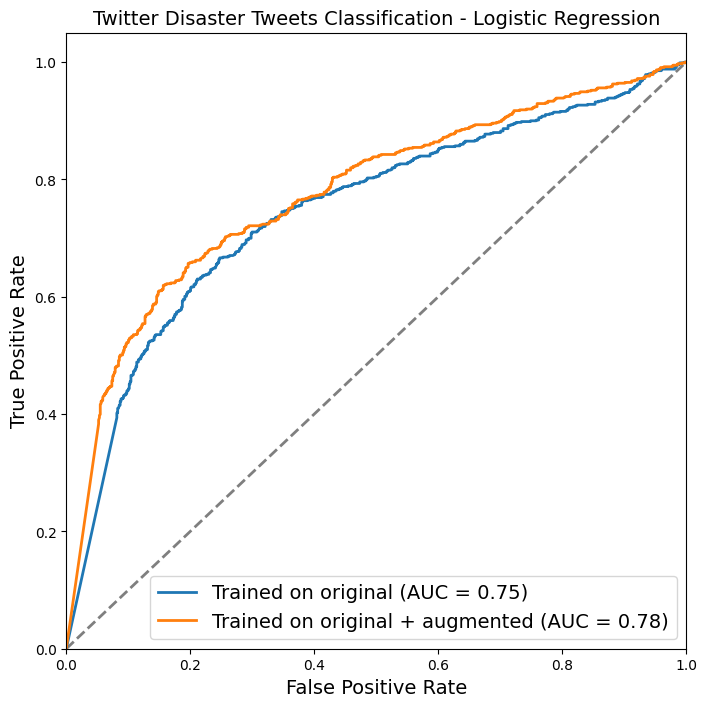

In [12]:
roc_logreg, auc_logreg = pt.get_roc_curves(y_ground_truth, y_mods_both_probs,
                                           model_names=['Trained on original', 'Trained on original + augmented'],
                                           plot_title='Twitter Disaster Tweets Classification - Logistic Regression')
print(auc_logreg)
roc_logreg.show()